In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail


In [2]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

In [3]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [4]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}
play_types_seasons_players = {}

    
def download_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='T', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict


def download_play_type_data_player(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons_players:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons_players[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons_players[season]

    
    return play_type_dict



In [4]:
last_year = download_play_type_data(season='2020-21')

Retrieving play types...


In [5]:
cur_year = download_play_type_data(season='2021-22')

Retrieving play types...


In [6]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["TEAM_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='TEAM_NAME')
    return final_df


def get_merged_data(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='TEAM_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [7]:
last_df = get_interesting_data(last_year, 'PTS')
cur_df = get_interesting_data(cur_year, 'PTS')

In [8]:
target_stat = 'PTS'
merged_df = get_merged_data(last_year, cur_year, target_stat)

In [9]:
diff_columns = [item for item in merged_df.columns.tolist() if '_diff' in item]

In [10]:
merged_df.loc[:, "EUCLIDEAN_DISTANCE"] = merged_df.loc[:, diff_columns].abs().sum(axis=1) ** (1/2)

In [11]:
merged_df.loc[:, "COSINE_SIMILARITY"] = merged_df.DOT_PRODUCT / (merged_df.LAST_NORM * merged_df.CUR_NORM)

In [12]:
merged_df.sort_values(by='COSINE_SIMILARITY')

,TEAM_NAME,PTS_PRBallHandler_last,PTS_Isolation_last,PTS_Transition_last,PTS_Spotup_last,PTS_Handoff_last,PTS_OffScreen_last,PTS_Cut_last,PTS_OffRebound_last,PTS_Postup_last,...,OffScreen_diff,Cut_diff,OffRebound_diff,Postup_diff,PRRollman_diff,LAST_NORM,CUR_NORM,DOT_PRODUCT,EUCLIDEAN_DISTANCE,COSINE_SIMILARITY
27,Washington Wizards,14.0,7.7,24.9,22.9,4.1,6.4,13.0,5.9,6.7,...,1.96,0.64,0.81,13.69,2.56,41.725172,37.872813,1514.34,12.110326,0.958292
13,Chicago Bulls,18.3,4.2,15.8,27.0,4.9,3.6,12.5,5.7,6.1,...,1.96,16.81,0.81,9.61,1.44,40.949969,41.297336,1651.76,8.879752,0.976723
7,Boston Celtics,19.8,7.3,18.5,26.2,5.5,4.9,9.2,6.9,4.4,...,0.04,0.01,0.81,0.36,0.64,41.452744,42.350443,1715.00,9.049309,0.976906
15,Philadelphia 76ers,17.4,5.7,20.8,25.4,5.4,2.3,6.8,7.2,11.8,...,0.16,0.81,4.84,23.04,1.44,41.497349,41.146203,1675.24,8.034924,0.981131
4,San Antonio Spurs,21.4,5.7,16.6,29.9,5.0,4.2,8.3,5.7,3.8,...,1.96,9.00,0.49,3.24,0.09,43.230660,42.397288,1800.88,8.041144,0.982550
3,Portland Trail Blazers,22.9,11.9,14.6,23.5,5.9,4.7,7.8,7.5,5.7,...,0.00,1.21,1.96,13.69,0.09,41.160175,40.223128,1627.34,7.574959,0.982936
19,Indiana Pacers,15.8,4.5,23.9,26.2,7.9,4.8,11.6,6.2,3.7,...,1.69,0.36,1.21,0.09,2.25,42.917712,39.532645,1667.71,8.327064,0.982942
8,LA Clippers,19.8,8.1,15.2,31.5,3.1,5.0,8.1,6.1,6.8,...,0.04,3.24,2.25,7.84,0.00,43.713270,39.450729,1698.50,8.379141,0.984912
9,Orlando Magic,19.5,3.6,14.6,22.9,6.6,5.5,7.3,6.9,5.4,...,5.29,2.89,0.01,1.96,5.29,37.441822,38.097113,1406.95,6.275349,0.986347
11,Phoenix Suns,18.4,6.2,19.9,29.3,3.7,5.4,9.8,5.4,6.1,...,0.81,0.49,1.00,9.61,16.00,43.491608,41.472159,1781.06,7.024244,0.987453


In [13]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas,
    ax=None
):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    ax.set_ylim(0, max_val)
    ax.spines['polar'].set_visible(False)

    ax.set_title(title, color='black', size=20, pad=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    #ax.set_yticks([item for item in range(0, 45, 10)])
    #ax.set_yticklabels([f"{item}" for item in range(0, 45, 10)], size=12)


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [14]:
plt.style.use('fivethirtyeight')

In [15]:
merged_df.sort_values(by='COSINE_SIMILARITY')

,TEAM_NAME,PTS_PRBallHandler_last,PTS_Isolation_last,PTS_Transition_last,PTS_Spotup_last,PTS_Handoff_last,PTS_OffScreen_last,PTS_Cut_last,PTS_OffRebound_last,PTS_Postup_last,...,OffScreen_diff,Cut_diff,OffRebound_diff,Postup_diff,PRRollman_diff,LAST_NORM,CUR_NORM,DOT_PRODUCT,EUCLIDEAN_DISTANCE,COSINE_SIMILARITY
27,Washington Wizards,14.0,7.7,24.9,22.9,4.1,6.4,13.0,5.9,6.7,...,1.96,0.64,0.81,13.69,2.56,41.725172,37.872813,1514.34,12.110326,0.958292
13,Chicago Bulls,18.3,4.2,15.8,27.0,4.9,3.6,12.5,5.7,6.1,...,1.96,16.81,0.81,9.61,1.44,40.949969,41.297336,1651.76,8.879752,0.976723
7,Boston Celtics,19.8,7.3,18.5,26.2,5.5,4.9,9.2,6.9,4.4,...,0.04,0.01,0.81,0.36,0.64,41.452744,42.350443,1715.00,9.049309,0.976906
15,Philadelphia 76ers,17.4,5.7,20.8,25.4,5.4,2.3,6.8,7.2,11.8,...,0.16,0.81,4.84,23.04,1.44,41.497349,41.146203,1675.24,8.034924,0.981131
4,San Antonio Spurs,21.4,5.7,16.6,29.9,5.0,4.2,8.3,5.7,3.8,...,1.96,9.00,0.49,3.24,0.09,43.230660,42.397288,1800.88,8.041144,0.982550
3,Portland Trail Blazers,22.9,11.9,14.6,23.5,5.9,4.7,7.8,7.5,5.7,...,0.00,1.21,1.96,13.69,0.09,41.160175,40.223128,1627.34,7.574959,0.982936
19,Indiana Pacers,15.8,4.5,23.9,26.2,7.9,4.8,11.6,6.2,3.7,...,1.69,0.36,1.21,0.09,2.25,42.917712,39.532645,1667.71,8.327064,0.982942
8,LA Clippers,19.8,8.1,15.2,31.5,3.1,5.0,8.1,6.1,6.8,...,0.04,3.24,2.25,7.84,0.00,43.713270,39.450729,1698.50,8.379141,0.984912
9,Orlando Magic,19.5,3.6,14.6,22.9,6.6,5.5,7.3,6.9,5.4,...,5.29,2.89,0.01,1.96,5.29,37.441822,38.097113,1406.95,6.275349,0.986347
11,Phoenix Suns,18.4,6.2,19.9,29.3,3.7,5.4,9.8,5.4,6.1,...,0.81,0.49,1.00,9.61,16.00,43.491608,41.472159,1781.06,7.024244,0.987453


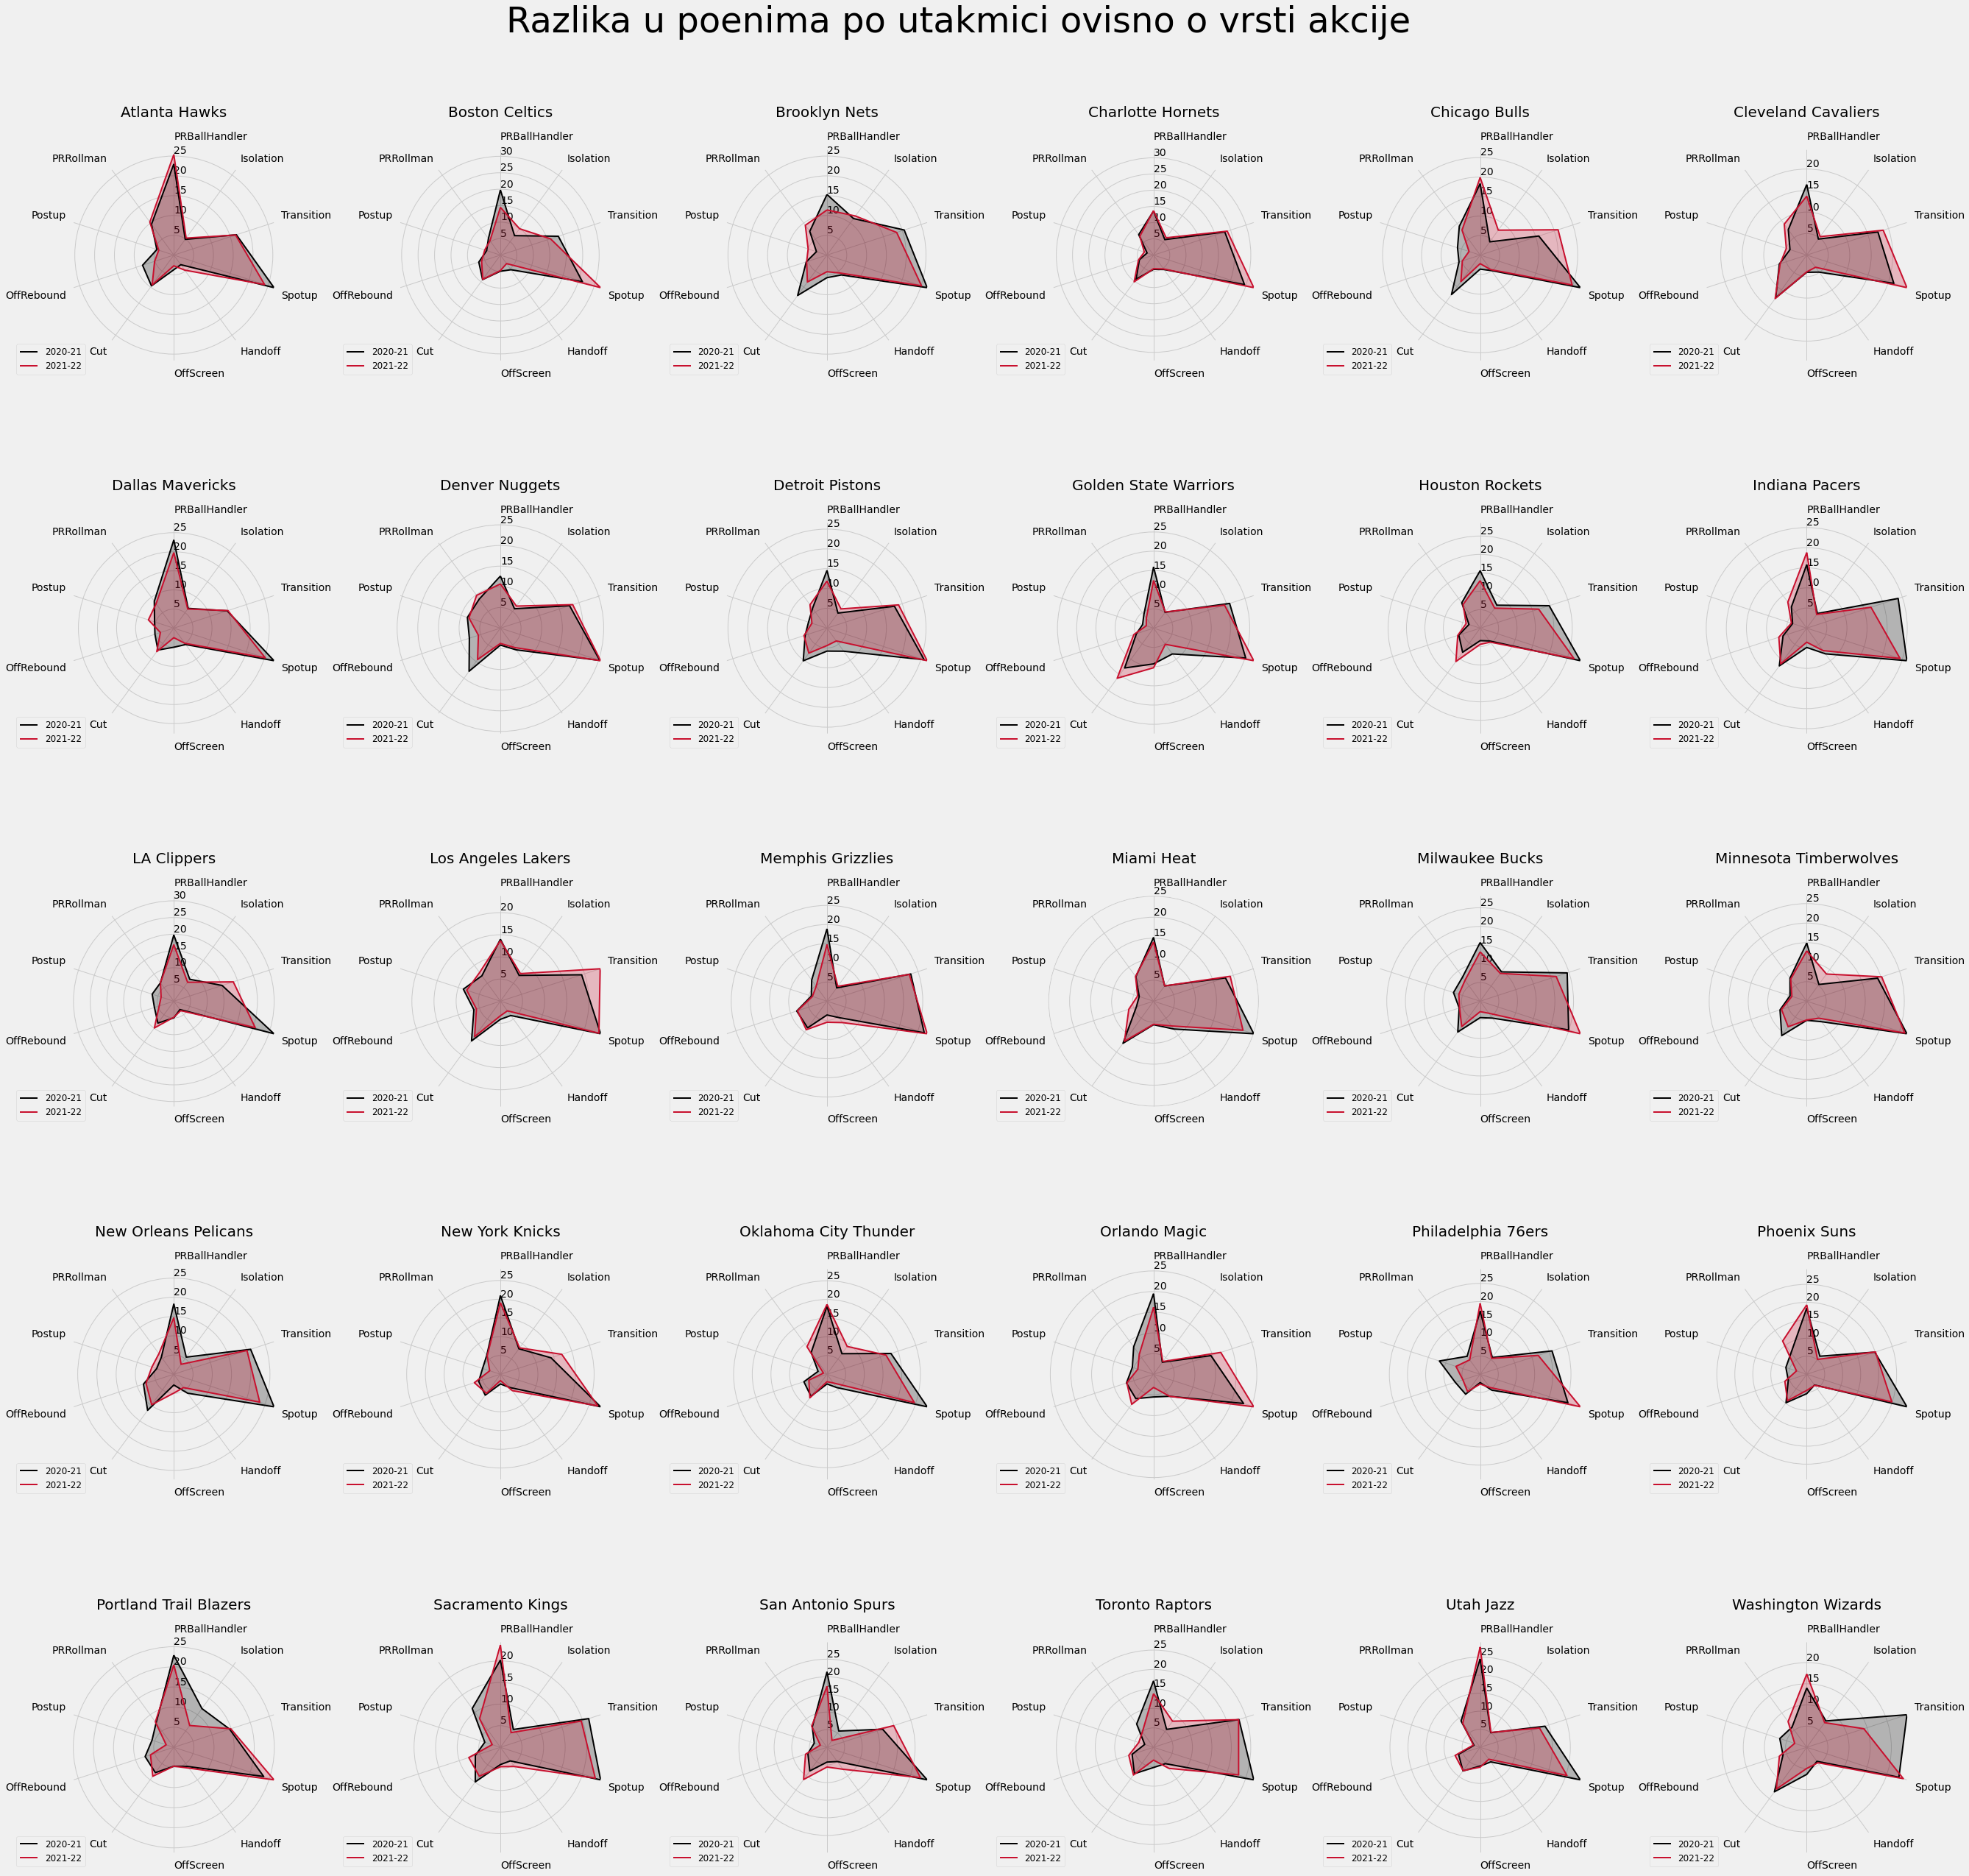

In [16]:
fig, axes = plt.subplots(5, 6, figsize=(40, 40), subplot_kw=dict(polar=True))

axes = axes.flatten()
merged_df = merged_df.sort_values(by='TEAM_NAME')
for index in range(len(merged_df)):
    item = merged_df.iloc[index]
    hou_last = merged_df.loc[merged_df.TEAM_NAME == item.TEAM_NAME, [column for column in merged_df.columns.tolist() if 'last' in column]]
    hou_cur = merged_df.loc[merged_df.TEAM_NAME == item.TEAM_NAME, [column for column in merged_df.columns.tolist() if 'cur' in column]]

    hou_last = hou_last.rename(columns={item: item.split("_last")[0].split("PTS_")[1] for item in hou_last.columns})
    hou_cur = hou_cur.rename(columns={item: item.split("_cur")[0].split("PTS_")[1] for item in hou_cur.columns})
    cur_ax = axes[index]
    plot_radar(
        title=f"{item.TEAM_NAME}",
        data=[hou_last.iloc[0], hou_cur.iloc[0]],
        labels=["2020-21", "2021-22"],
        colors=[
            "#000000",
            "#C8102E"
        ],
        alphas=[0.25, 0.25],
        ax=cur_ax
    )
    axes[index] = cur_ax
    
plt.suptitle("Razlika u poenima po utakmici ovisno o vrsti akcije", size=48)
plt.subplots_adjust(wspace=0.55, hspace=0.00001, top=0.95)
plt.savefig('radar_diff.png', dpi=120, bbox_inches='tight')

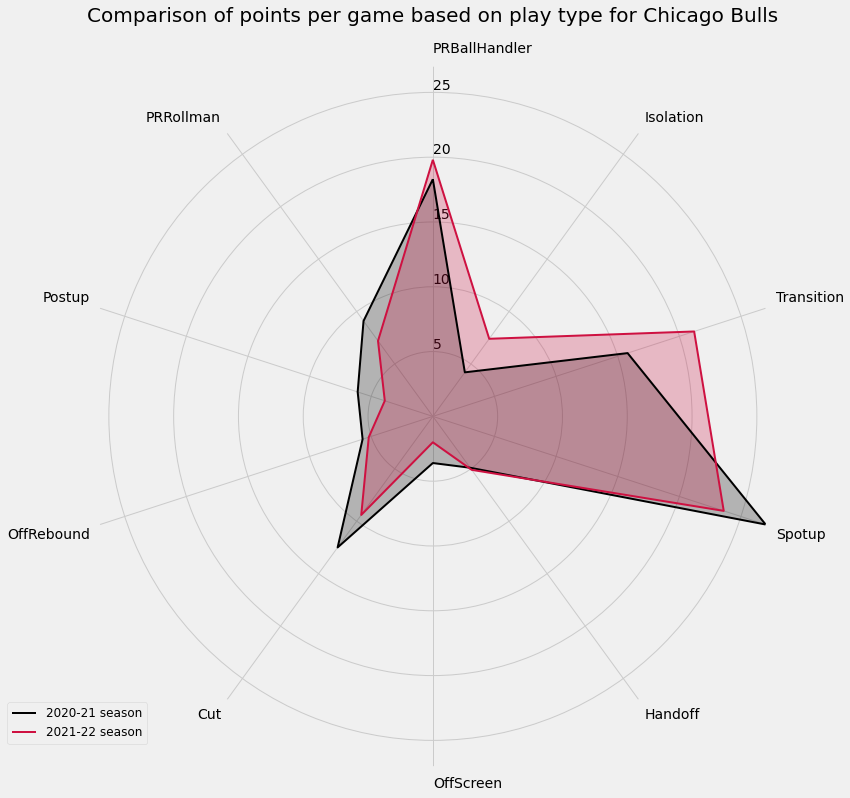

In [17]:
team_name = 'Chicago Bulls'
team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
team_cur = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'cur' in column]]

team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Comparison of points per game based on play type for {team_name}",
    data=[team_last.iloc[0], team_cur.iloc[0]],
    labels=["2020-21 season", "2021-22 season"],
    colors=[
        "#000000",
        "#CE1141"
    ],
    alphas=[0.25, 0.25]
)

## PLAYER

In [20]:
def get_interesting_data_player(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["PLAYER_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='PLAYER_NAME').fillna(0.0)
    return final_df


def get_merged_data_player(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data_player(first_year, target_column)
    second_df = get_interesting_data_player(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='PLAYER_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [9]:
last_year = download_play_type_data_player(season='2020-21')

cur_year = download_play_type_data_player(season='2021-22')

In [21]:
last_df = get_interesting_data_player(last_year, 'PTS')
cur_df = get_interesting_data_player(cur_year, 'PTS')

target_stat = 'PTS'
merged_df = get_merged_data_player(last_year, cur_year, target_stat)

diff_columns = [item for item in merged_df.columns.tolist() if '_diff' in item]

merged_df.loc[:, "EUCLIDEAN_DISTANCE"] = merged_df.loc[:, diff_columns].abs().sum(axis=1) ** (1/2)

merged_df.loc[:, "COSINE_SIMILARITY"] = merged_df.DOT_PRODUCT / (merged_df.LAST_NORM * merged_df.CUR_NORM)

In [22]:
merged_df.sort_values(by='COSINE_SIMILARITY', ascending=True)

,PLAYER_NAME,PTS_PRBallHandler_last,PTS_Isolation_last,PTS_Transition_last,PTS_Spotup_last,PTS_Handoff_last,PTS_OffScreen_last,PTS_Cut_last,PTS_OffRebound_last,PTS_Postup_last,...,OffScreen_diff,Cut_diff,OffRebound_diff,Postup_diff,PRRollman_diff,LAST_NORM,CUR_NORM,DOT_PRODUCT,EUCLIDEAN_DISTANCE,COSINE_SIMILARITY
7,Harrison Barnes,1.5,1.0,2.9,4.0,0.9,0.2,1.4,0.6,1.5,...,0.36,0.09,0.01,1.44,0.64,5.943904,7.207635,40.34,2.569047,0.941611
2,Tobias Harris,4.2,1.6,4.1,2.7,0.8,0.4,0.9,0.8,2.7,...,0.01,0.00,0.00,0.16,0.00,7.348469,7.353911,50.95,2.485961,0.942820
0,Jayson Tatum,6.8,3.9,4.3,3.5,1.6,1.3,1.1,0.5,2.0,...,0.81,0.04,0.09,0.49,0.00,10.112369,9.728823,93.67,3.093542,0.952110
9,Karl-Anthony Towns,0.4,1.9,2.1,4.4,0.8,1.8,1.6,2.6,4.4,...,0.36,0.49,0.16,2.25,0.49,8.590111,8.321058,68.66,2.389561,0.960564
1,Brandon Ingram,6.7,2.5,3.4,5.3,1.8,1.7,0.6,0.2,0.4,...,1.96,0.16,0.04,0.49,0.01,9.877753,8.539906,81.54,2.723968,0.966628
4,Gordon Hayward,3.2,1.0,4.3,3.7,2.1,1.2,1.5,0.5,0.8,...,0.01,0.09,0.04,0.16,0.04,7.250517,6.302381,44.35,1.894730,0.970555
5,Jerami Grant,2.5,2.2,2.8,6.1,2.2,2.1,0.9,0.6,0.8,...,0.09,0.09,0.01,0.04,1.00,8.333667,7.584194,61.37,2.056696,0.970981
8,Miles Bridges,0.8,0.5,2.3,4.3,0.4,0.3,1.5,0.6,0.4,...,0.36,0.09,0.01,0.09,0.64,5.397222,7.582216,39.94,2.596151,0.975982
3,LeBron James,5.1,3.7,5.6,2.1,0.6,0.5,2.1,0.4,3.6,...,0.00,0.16,0.01,0.16,0.25,9.688137,10.746627,102.85,1.910497,0.987852
6,Bojan Bogdanovic,1.4,0.5,3.6,5.7,0.7,1.8,0.7,0.4,1.4,...,0.25,0.04,0.01,0.16,0.04,7.354590,7.578918,55.30,0.964365,0.992109
